<a href="https://colab.research.google.com/github/PraeJi/Deep-Learning-for-Image/blob/main/Object_Detection(Yolov5).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [35]:
!nvidia-smi

Wed Aug 28 01:51:36 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8              10W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# Introduction object detection

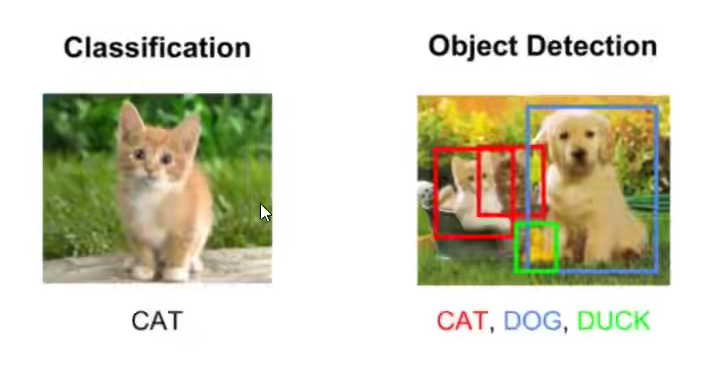

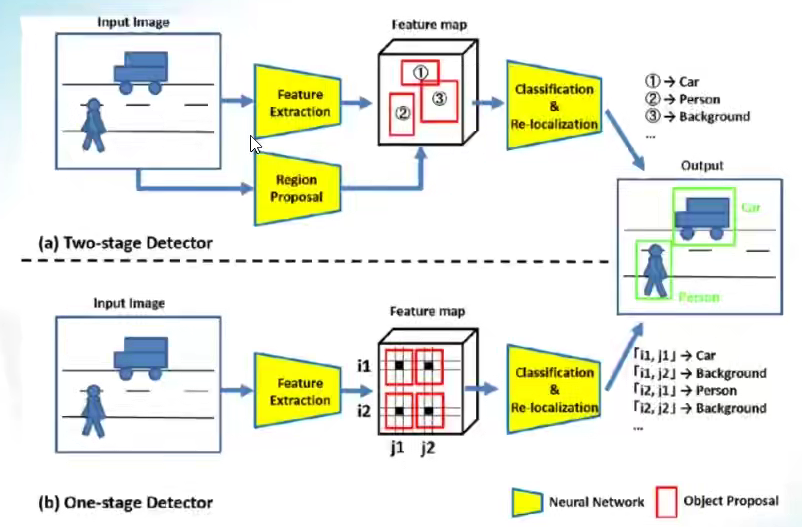

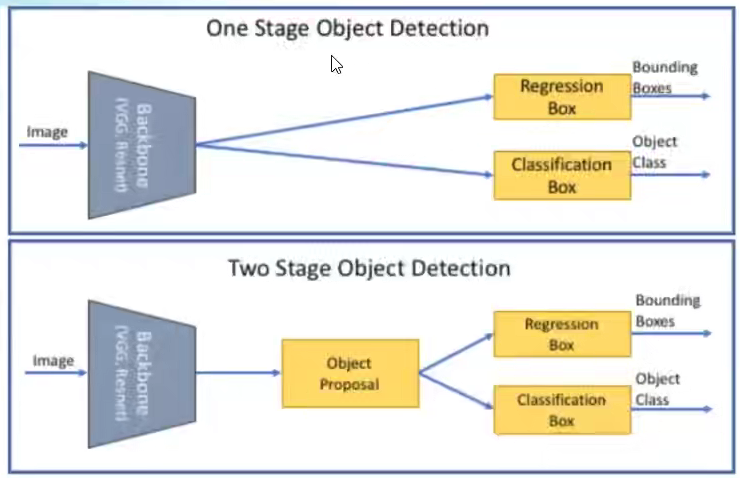

# 1.Install Yolov5 From git

https://github.com/ultralytics/yolov5

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image,ImageDraw
from IPython import display

In [37]:
import torch

In [38]:
device = ("cuda" if torch.cuda.is_available() else "cpu")
device

'cuda'

In [39]:
!git clone https://github.com/ultralytics/yolov5.git

Cloning into 'yolov5'...
remote: Enumerating objects: 16923, done.
remote: Counting objects: 100% (118/118), done.
remote: Compressing objects: 100% (83/83), done.
remote: Total 16923 (delta 57), reused 73 (delta 35), pack-reused 16805 (from 1)
Receiving objects: 100% (16923/16923), 15.70 MiB | 29.03 MiB/s, done.
Resolving deltas: 100% (11590/11590), done.


In [40]:
!pwd

/content/yolov5


In [41]:
%cd yolov5

/content/yolov5/yolov5


In [42]:
!git clone https://git-ai.inet-th.net/suphanat.bo/kong_dataset_dogcat.git

Cloning into 'kong_dataset_dogcat'...
remote: Enumerating objects: 11362, done.
remote: Counting objects: 100% (21/21), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 11362 (delta 13), reused 9 (delta 9), pack-reused 11341 (from 1)
Receiving objects: 100% (11362/11362), 265.99 MiB | 3.65 MiB/s, done.
Resolving deltas: 100% (3813/3813), done.
Updating files: 100% (11077/11077), done.


In [43]:
img = Image.open('/content/yolov5/kong_dataset_dogcat/images/Cats_Test0.jpg').convert('RGB')
print(img.size)
print(plt.imshow(img))

(233, 350)
AxesImage(size=(350, 233))


In [44]:
df = pd.read_csv('/content/yolov5/kong_dataset_dogcat/data.csv')
df

,filename,width,height,xmin,ymin,xmax,ymax,label
0,Cats_Test3387.jpg,500,375,179,69,315,199,dog
1,Cats_Test3261.jpg,334,500,109,17,263,162,dog
2,Cats_Test1566.jpg,375,500,108,197,256,359,dog
3,Cats_Test2617.jpg,500,335,148,1,373,215,cat
4,Cats_Test3281.jpg,375,500,1,96,341,446,dog
...,...,...,...,...,...,...,...,...
3681,Cats_Test1683.jpg,500,375,227,24,359,156,cat
3682,Cats_Test3256.jpg,500,333,213,53,311,162,dog
3683,Cats_Test1778.jpg,333,500,36,74,166,211,cat
3684,Cats_Test932.jpg,479,500,33,44,415,396,dog


In [45]:
df['label'].value_counts()

,count
label,
dog,2498
cat,1188


In [46]:
df['filename'][1]

'Cats_Test3261.jpg'

In [47]:
i=0
path_img = '/content/yolov5/kong_dataset_dogcat/images/'

im = Image.open(path_img + df['filename'][i]).convert('RGB')
print(im.size)
print(df['label'][i])
plt.imshow(im)

(500, 375)
dog


In [48]:
i=0
path_img = '/content/yolov5/kong_dataset_dogcat/images/'
im = Image.open(path_img + df['filename'][i]).convert('RGB')
print(im.size)
print(df['label'][i])

draw = ImageDraw.Draw(im)
draw.rectangle((180,60,300,200),width=5,outline="red") #xmin,ymin,xmax,ymax ,width=>ค.หนากรอบ
plt.imshow(im)

(500, 375)
dog


In [49]:
df['label'][0]

'dog'

In [50]:
df[['xmin','ymin','xmax','ymax']].iloc[0] # 2 dim use iloc

,0
xmin,179
ymin,69
xmax,315
ymax,199


In [51]:
i = 0
path_img = '/content/yolov5/kong_dataset_dogcat/images/'
im = Image.open(path_img + df['filename'][i]).convert('RGB')
print("Size :",im.size)
print("Label :",df['label'][0])
print(df[['xmin','ymin','xmax','ymax']].iloc[i])

draw = ImageDraw.Draw(im)
boxs = df[['xmin','ymin','xmax','ymax']].iloc[i]
draw.rectangle(boxs,width=5,outline="red")
plt.imshow(im)

Size : (500, 375)
Label : dog
xmin    179
ymin     69
xmax    315
ymax    199
Name: 0, dtype: int64


/usr/local/lib/python3.10/dist-packages/PIL/ImageDraw.py:296: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  self.draw.draw_rectangle(xy, ink, 0, width)


# 2.Create dataset

In [52]:
from kong_dataset_dogcat.set_pytorch.object_detection.load_dataset import LoadDataset

In [53]:
custom_data = LoadDataset(
    img_path= '/content/yolov5/kong_dataset_dogcat/images/',
    dataframe= df,
    x_col= 'filename',
    y_col='label',
    )

!Please use format box_col :['xmin','ymin','xmax','ymax']!


In [54]:
#ใช้ formate การโหลด data อันนี้
custom_data = LoadDataset(
    img_path= '/content/yolov5/kong_dataset_dogcat/images/',
    dataframe= df,
    x_col= 'filename',
    y_col='label',
    box_col=['xmin','ymin','xmax','ymax'],
    )

In [55]:
len(custom_data)

3686

In [56]:
custom_data.get_dataframe()

,filename,width,height,xmin,ymin,xmax,ymax,label
0,Cats_Test3387.jpg,500,375,179,69,315,199,dog
1,Cats_Test3261.jpg,334,500,109,17,263,162,dog
2,Cats_Test1566.jpg,375,500,108,197,256,359,dog
3,Cats_Test2617.jpg,500,335,148,1,373,215,cat
4,Cats_Test3281.jpg,375,500,1,96,341,446,dog
...,...,...,...,...,...,...,...,...
3681,Cats_Test1683.jpg,500,375,227,24,359,156,cat
3682,Cats_Test3256.jpg,500,333,213,53,311,162,dog
3683,Cats_Test1778.jpg,333,500,36,74,166,211,cat
3684,Cats_Test932.jpg,479,500,33,44,415,396,dog


In [57]:
custom_data.label_

{'cat': 0, 'dog': 1}

In [58]:
custom_data.plot_image(i)

In [59]:
custom_data.multi_plot_image()

#3.Prepare the directory

In [60]:
train_ = LoadDataset(
    img_path= '/content/yolov5/kong_dataset_dogcat/images/',
    dataframe= df,
    x_col= 'filename',
    y_col= 'label',
    box_col=['xmin','ymin','xmax','ymax'],
    subset='train',
    split=(0.7,0.2,0.1), #%train,%test,%valid
)

val_ = LoadDataset(
    img_path= '/content/yolov5/kong_dataset_dogcat/images/',
    dataframe= df,
    x_col= 'filename',
    y_col= 'label',
    box_col=['xmin','ymin','xmax','ymax'],
    subset='valid',
    split=(0.7,0.2,0.1),
)

test_ = LoadDataset(
    img_path= '/content/yolov5/kong_dataset_dogcat/images/',
    dataframe= df,
    x_col= 'filename',
    y_col= 'label',
    box_col=['xmin','ymin','xmax','ymax'],
    subset='test',
    split=(0.7,0.2,0.1),
)

In [61]:
print(len(train_))
print(len(test_))
print(len(val_))

2653
738
295


In [62]:
train_.dataloader()
test_.dataloader()
val_.dataloader()

100%|██████████| 295/295 [00:01<00:00, 222.86it/s]


In [63]:
train_.multi_plot_image()

#4.Train Model

In [64]:
IMG_SIZE = 224
BATCH_SIZE = 16
EPOCHS = 15

In [65]:
!python train.py --img {IMG_SIZE} \
                 --batch {BATCH_SIZE} \
                 --epochs {EPOCHS} \
                 --data '/content/yolov5/data/data.yaml' \
                 --weights yolov5s.pt

Streaming output truncated to the last 5000 lines.
       0/14     0.484G     0.1138    0.01325    0.02973         30        224:  20% 33/166 [00:12<00:43,  3.04it/s]/content/yolov5/yolov5/train.py:412: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(amp):
       0/14     0.484G     0.1135    0.01333    0.02966         33        224:  20% 34/166 [00:12<00:42,  3.11it/s]/content/yolov5/yolov5/train.py:412: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(amp):
       0/14     0.484G     0.1131    0.01346    0.02961         37        224:  21% 35/166 [00:12<00:42,  3.12it/s]/content/yolov5/yolov5/train.py:412: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(amp):
       0/14  

# 5.Evaluation Model

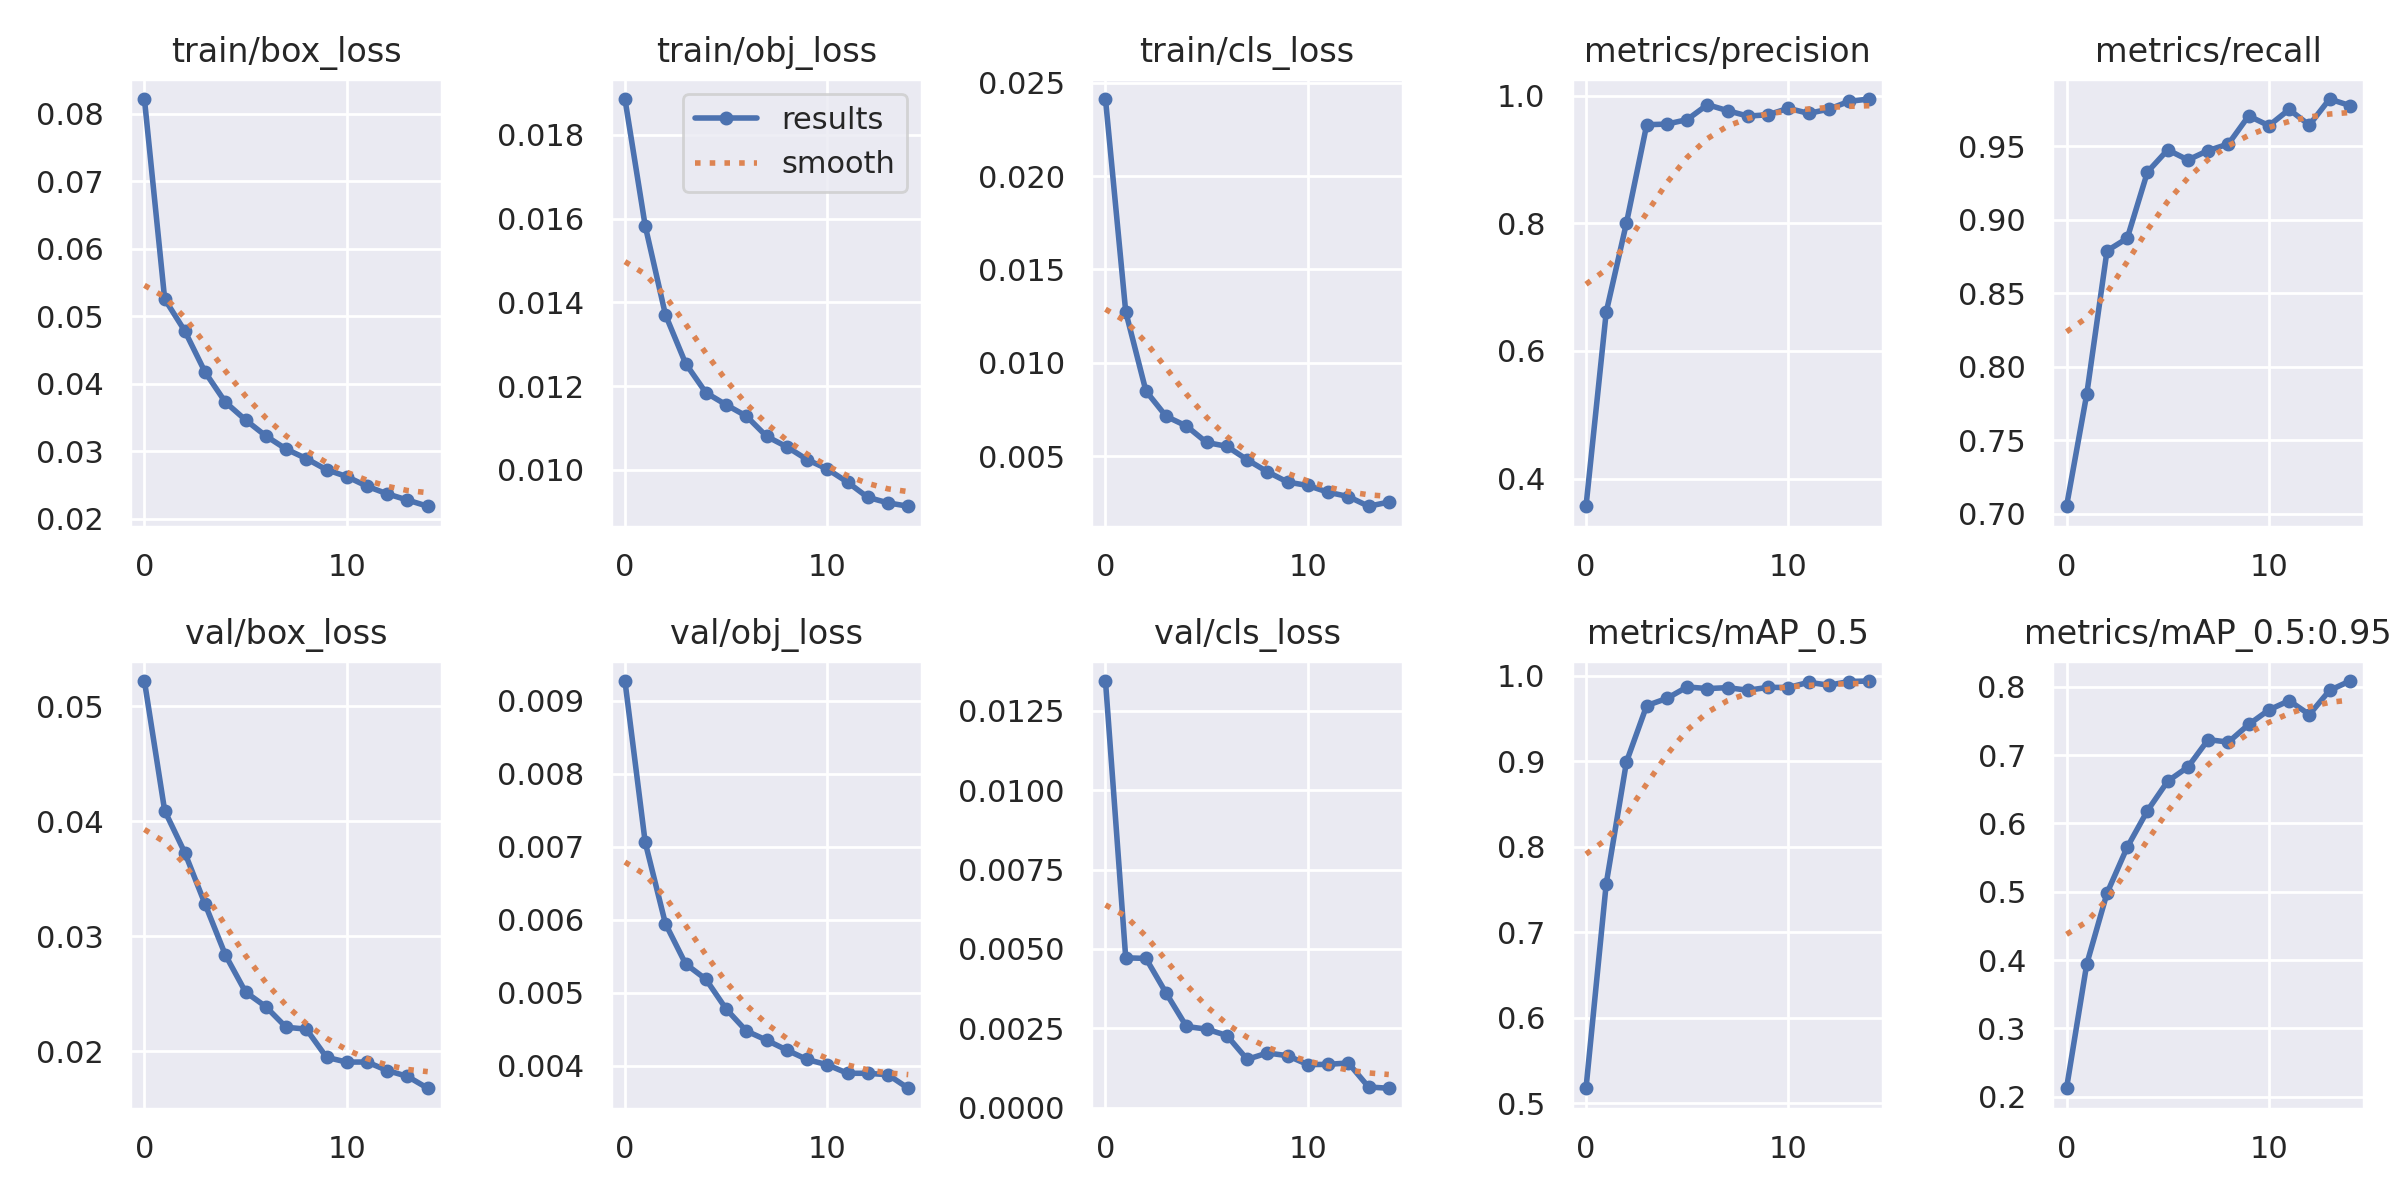

In [72]:
display.Image('/content/yolov5/yolov5/runs/train/exp/results.png')

# 6.Test Model

In [70]:
from kong_dataset_dogcat.set_pytorch.object_detection.load_model import Model

In [73]:
MODEL_PATH = '/content/yolov5/yolov5/runs/train/exp/weights/best.pt'
model = Model(MODEL_PATH,224,device=device)

YOLOv5 🚀 v7.0-361-gc5ffbbf1 Python-3.10.12 torch-2.4.0+cu121 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
Model summary: 157 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs


In [74]:
model.summary()

DetectMultiBackend(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 32, kernel_size=(6, 6), stride=(2, 2), padding=(2, 2))
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (act): SiLU(inplace=True)
      )
      (2): C3(
        (cv1): Conv(
          (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
          (act): SiLU(inplace=True)
        )
        (cv3): Conv(
          (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
          (act): SiLU(inplace=True)
        )
        (m): Sequential(
          (0): Bottleneck(
            (cv1): Conv(
              (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
              (act): SiLU(inplace=True)
            )
            (cv2): Conv(

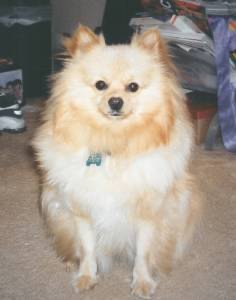

In [75]:
test_[1]

WARNING ⚠️ NMS time limit 0.550s exceeded


<PIL.Image.Image image mode=RGB size=236x300 at 0x7DF6318C9210>


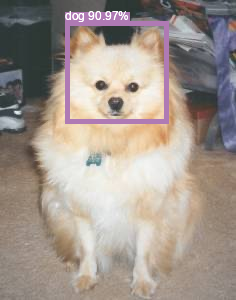

In [76]:
print(model.predict_image(test_[1]))
model.predict_image(test_[1])

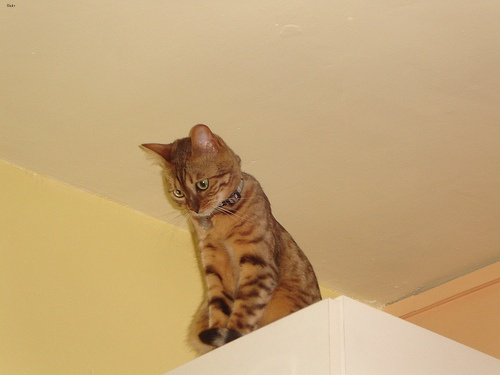

In [77]:
test_[3]

<PIL.Image.Image image mode=RGB size=500x375 at 0x7DF6318C9180>


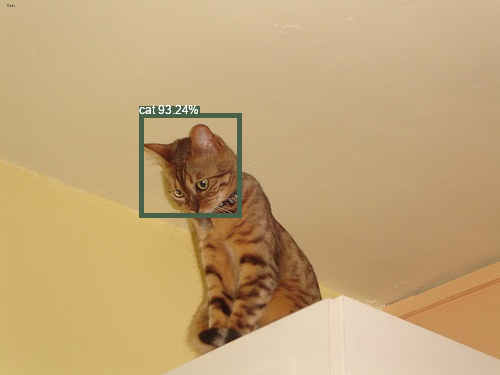

In [78]:
print(model.predict_image(test_[3]))
model.predict_image(test_[3])

In [79]:
model.Confusion_Matrix(data='/content/yolov5/data/data_test.yaml')

val: Scanning /content/datasets/labels/test... 738 images, 0 backgrounds, 0 corrupt: 100%|██████████| 738/738 [00:00<00:00, 2090.16it/s]
val: New cache created: /content/datasets/labels/test.cache
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100%|██████████| 24/24 [00:06<00:00,  3.97it/s]
                   all        738        738      0.972      0.986      0.991      0.842
                   cat        738        252      0.965      0.992      0.994      0.879
                   dog        738        486      0.979      0.979      0.988      0.805


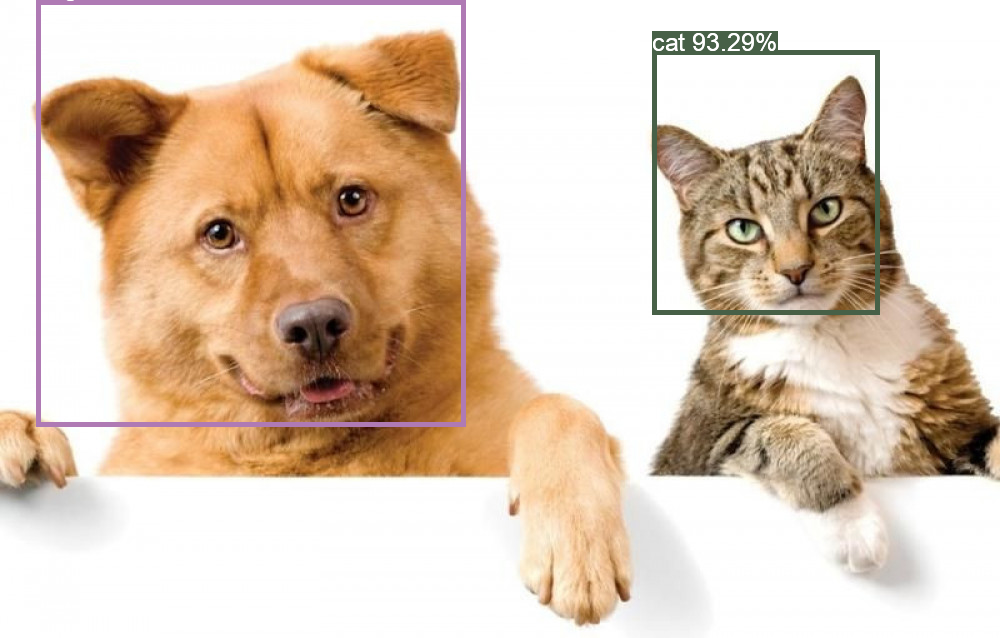

In [80]:
test_path = '/content/yolov5/kong_dataset_dogcat/16E2CB2CC41B4CB980FC4480DC146122_1000.jpg'
image = Image.open(test_path).convert('RGB')
model.predict_image(image)

In [81]:
!wget https://petloverthailand.com/wp-content/uploads/2019/08/9598-1024x536.jpg

--2024-08-28 02:15:46--  https://petloverthailand.com/wp-content/uploads/2019/08/9598-1024x536.jpg
Resolving petloverthailand.com (petloverthailand.com)... 172.67.197.250, 104.21.76.173, 2606:4700:3037::ac43:c5fa, ...
Connecting to petloverthailand.com (petloverthailand.com)|172.67.197.250|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 50902 (50K) [image/jpeg]
Saving to: ‘9598-1024x536.jpg’

9598-1024x536.jpg   100%[===================>]  49.71K  --.-KB/s    in 0.008s  

2024-08-28 02:15:46 (6.09 MB/s) - ‘9598-1024x536.jpg’ saved [50902/50902]



[tensor([[175.38324,  68.90392, 215.33224, 106.37039,   0.90724,   0.00000],
        [ 23.38538,   5.07994,  51.49858,  38.80048,   0.89434,   0.00000],
        [127.63739,  51.15156, 169.92816,  80.37857,   0.88397,   1.00000],
        [ 71.71385,  10.45315, 117.95355,  60.20194,   0.88170,   1.00000]], device='cuda:0')]


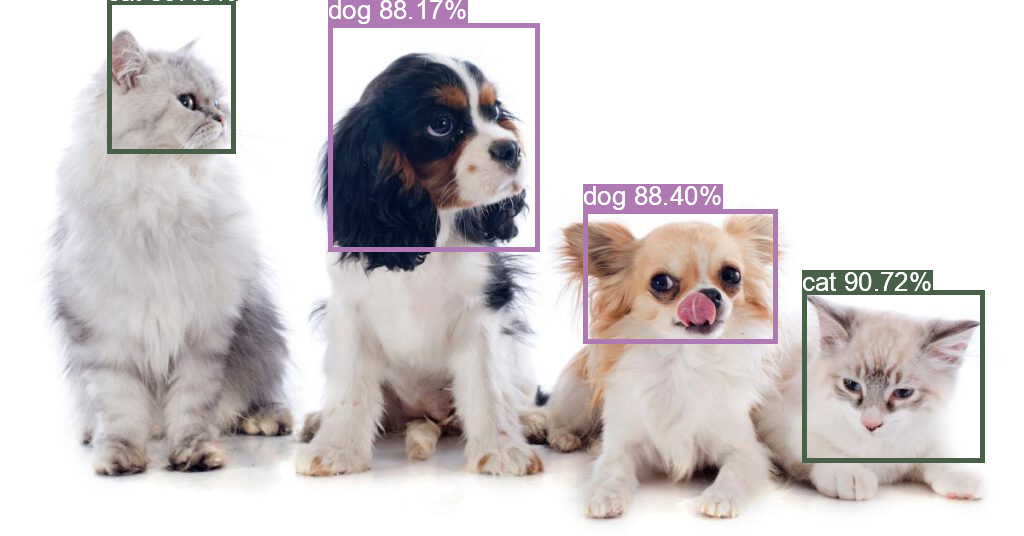

In [82]:
test_path = '9598-1024x536.jpg'
image = Image.open(test_path).convert('RGB')
print(model.prediction(image))
model.predict_image(image)